to troubleshoot the new attempted objective situation - dig into:
- does the new flux constraint make sense?
    - I don't think it does - sent message to Daniel to ask for clarification.
- does the the objectvie from cobrapy carry over into comets?
    - It does not seem like it does - honestly what?? I don't understand how the objective function is picked when the cobrapy model is converted to comets.
- is it possible to get RA and biomass at the same time in an environment with lots of SA/CA? (try with static sim.)
    - Is possible with static sim!

In [27]:
import pandas as pd
import functions.data_analysis as data_analysis

# read data
relative_abundance_df = pd.read_csv("exp_data/subpop_data_xyl_glc.csv")
products_df = pd.read_csv("exp_data/conc_data_xyl_glc.csv")
od600_df = pd.read_csv("exp_data/od600_xyl_glc.csv")

subpop_df, conc_df, OD_df = data_analysis.process_data(relative_abundance_df, products_df, od600_df)

growth_curves = data_analysis.get_growth_curves(OD_df, subpop_df, ["CAL11", "SAL11", "MAM3"])

CA_yield, SAA_yield, RA_yield = data_analysis.get_yields_glc_xyl(conc_df)

CA yield 0.11827464690243904 g CA per g xylose
SAA yield 0.04310857623772063 g SAA per g glucose
RA yield 0.22317273168831167 g RA per g xylose


In [2]:
## 19. nov - new flux coupling constraints.

from cobra.io import read_sbml_model
from functions.modify_GEM import add_ratio_constraint_cobra

# ----- read cobrapy models -----

CAL11_cobra = read_sbml_model("GEMs/CAL11.xml")
SAL11_cobra = read_sbml_model("GEMs/SAL11.xml")
MAM3_cobra = read_sbml_model("GEMs/MAM3.xml")

# flux coupling constraint:  production of RA / uptake of CA (or SA) = measured yield

# knock out GLCtex_copy1 in SAL9, just so I have one less thing to worry about...
SAL11_cobra.reactions.get_by_id("GLCtex_copy1").bounds = (0.0, 0.0)

add_ratio_constraint_cobra(CAL11_cobra, "34DHCINMt", "XYLtex", CA_yield);
add_ratio_constraint_cobra(SAL11_cobra, "SAAt", "GLCtex_copy2", SAA_yield);
#add_ratio_constraint_cobra(MAM3_cobra, "RAt", "SAAt", RA_yield);

# model objective function:  biomass + production of RA
# new_objective = MAM3_cobra.problem.Objective(
#     MAM3_cobra.reactions.RAt.flux_expression, 
#     #+ MAM3_cobra.reactions.BIOMASS_Ec_iML1515_core_75p37M.flux_expression,
#     direction='max'
# )
#
# MAM3_cobra.objective = new_objective

MAM3_cobra.objective = {MAM3_cobra.reactions.RAt: 1.0}#, MAM3_cobra.reactions.BIOMASS_Ec_iML1515_core_75p37M: 1.0}

In [10]:
MAM3_cobra.objective.expression

1.0*RAt - 1.0*RAt_reverse_6b5d8

In [4]:
MAM3_cobra.reactions.EX_saa_e.lower_bound = -10
MAM3_cobra.reactions.EX_34dhcinm_e = -10

In [5]:
solution = MAM3_cobra.optimize()
print(solution["BIOMASS_Ec_iML1515_core_75p37M"])
print(solution["EX_rosma_e"])

0.651296635952149
10.0


In [3]:
import cometspy as c

initial_pop_ratio =(2, 1, 1)
glc_xyl_mmol = (1.67, 1.33)
initial_pop=3.9e-3

# in order to equal the playing field between BL21 and K12 derived models:

# adjust the biomass reaction
SAL11_cobra.reactions.get_by_id("BIOMASS_Ec_iHK1487_core").add_metabolites({"atp_c":-75.55223}, combine=False)
SAL11_cobra.reactions.get_by_id("BIOMASS_Ec_iHK1487_core").add_metabolites({"h_c":75.377230}, combine=False)
SAL11_cobra.reactions.get_by_id("BIOMASS_Ec_iHK1487_core").add_metabolites({"adp_c":75.377230}, combine=False)
SAL11_cobra.reactions.get_by_id("BIOMASS_Ec_iHK1487_core").add_metabolites({"pi_c":75.373230}, combine=False)
SAL11_cobra.reactions.get_by_id("BIOMASS_Ec_iHK1487_core").add_metabolites({"h2o_c":-70.028756}, combine=False)

# adjust the ATP maintanance requrenment
SAL11_cobra.reactions.ATPM.lower_bound = 6.86 

# make comets models
cal11_c = c.model(CAL11_cobra)
sal11_c = c.model(SAL11_cobra)
mam3_c = c.model(MAM3_cobra)

cal11_c.initial_pop = [0,0,initial_pop*initial_pop_ratio[0]]
sal11_c.initial_pop = [0,0,initial_pop*initial_pop_ratio[1]]
mam3_c.initial_pop = [0,0,initial_pop*initial_pop_ratio[2]]

# open the exhange reactions
cal11_c.open_exchanges()
sal11_c.open_exchanges()
mam3_c.open_exchanges()

In [30]:
import cometspy as c
from cobra.io import read_sbml_model

MAM3_cobra = read_sbml_model("GEMs/MAM3.xml")
MAM3_cobra.objective = {MAM3_cobra.reactions.RAt: 1.0, MAM3_cobra.reactions.BIOMASS_Ec_iML1515_core_75p37M: 1.0}
mam3_c = c.model(MAM3_cobra)

In [33]:
MAM3_cobra.objective = {MAM3_cobra.reactions.RAt: 3.0, MAM3_cobra.reactions.BIOMASS_Ec_iML1515_core_75p37M: 1.0}
MAM3_cobra.objective.expression

1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685 + 3.0*RAt - 3.0*RAt_reverse_6b5d8

In [21]:
mam3_c.objective

2669

In [22]:
mam3_c.get_reaction_names()[mam3_c.objective - 1]

'BIOMASS_Ec_iML1515_core_75p37M'

going to attempt to run multiple simulations with and without the new objective function - just to see weather it makes any difference

In [24]:
from cobra.io import read_sbml_model
from functions.dfba_comets import simulate_xyl_glc_triculture

# ----- read cobrapy models -----
CAL11_cobra = read_sbml_model("GEMs/CAL11.xml")
SAL11_cobra = read_sbml_model("GEMs/SAL11.xml")
MAM3_cobra = read_sbml_model("GEMs/MAM3.xml")

sim = simulate_xyl_glc_triculture(CAL11_cobra, SAL11_cobra, MAM3_cobra, initial_pop=3.9e-3, adjust_atp_requirements=True)


Running COMETS simulation ...
Done!


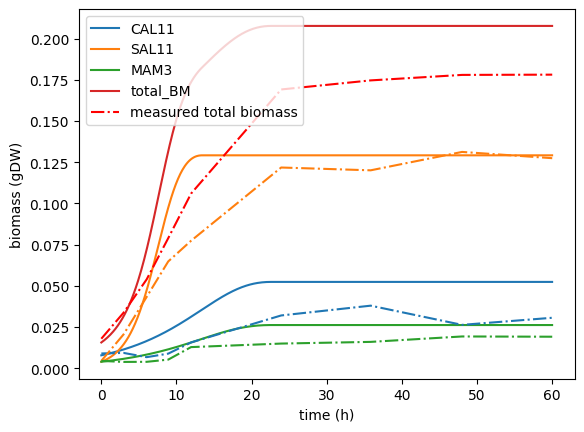

In [28]:
from functions.plot_results import plot_biomass_time_course

plot_biomass_time_course(sim.total_biomass, OD_df, growth_curves)

In [34]:
from cobra.io import read_sbml_model
from functions.dfba_comets import simulate_xyl_glc_triculture

# ----- read cobrapy models -----
# CAL11_cobra = read_sbml_model("GEMs/CAL11.xml")
# SAL11_cobra = read_sbml_model("GEMs/SAL11.xml")
# MAM3_cobra = read_sbml_model("GEMs/MAM3.xml")
# MAM3_cobra.objective = {MAM3_cobra.reactions.RAt: 1.0, MAM3_cobra.reactions.BIOMASS_Ec_iML1515_core_75p37M: 1.0}
MAM3_cobra.objective = {MAM3_cobra.reactions.RAt: 3.0, MAM3_cobra.reactions.BIOMASS_Ec_iML1515_core_75p37M: 1.0}

sim_adjusted = simulate_xyl_glc_triculture(CAL11_cobra, SAL11_cobra, MAM3_cobra, initial_pop=3.9e-3, adjust_atp_requirements=True)


Running COMETS simulation ...
Done!


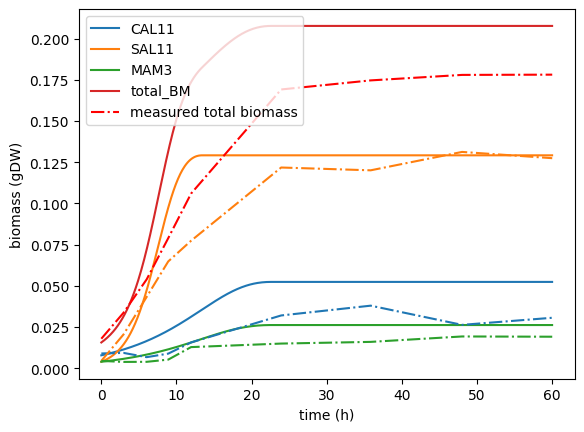

In [35]:
plot_biomass_time_course(sim_adjusted.total_biomass, OD_df, growth_curves)